Load the dataset

In [2]:
from datasets import load_dataset, load_metric

code_dataset = load_dataset("json", data_files="perturbations/defects4j_generated_hunk.json", field="bugs")
code_dataset

Using custom data configuration default-cfe4d697bf0d4714


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/andre/.cache/huggingface/datasets/json/default-cfe4d697bf0d4714/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['identifier', 'path', 'diff'],
        num_rows: 96803
    })
})

In [4]:
from unidiff import PatchSet

def source_str(example):
    diff = PatchSet(example)
    source = ""
    for line in diff[0][0].target_lines():
        if line.is_added:
            source += " [START_BUGGY] " + line.value.strip() + " [END_BUGGY]"
        else:
            source += line.value.strip()
    return source
        
def target_str(example):
    diff = PatchSet(example)
    target = ""
    for line in diff[0][0].source_lines():
        target += line.value.strip()
    return target

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./models/test_run")
tokenizer.add_tokens(["[START_BUGGY]", "[END_BUGGY]"])
tokenizer

PreTrainedTokenizer(name_or_path='./models/test_run', vocab_size=50005, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['java', 'python', 'en_XX']})

In [17]:
print(code_dataset["train"][0]["diff"])

--- /home/andre/Repos/mscthesis/perturbations/defects4j/Closure-106/src/com/google/javascript/rhino/Parser.java	2022-04-13 14:11:14.378630374 +0100
+++ /tmp/tmpeuh8q3lp.java	2022-05-06 15:48:33.320562632 +0100
@@ -1557,11 +1557,11 @@
     }
 
     private Node bitAndExpr(boolean inForInit)
         throws IOException, JavaScriptException
     {
-        Node pn = eqExpr(inForInit);
+
         while (matchToken(Token.BITAND)) {
             int lineno = ts.getLineno();
             int charno = ts.getCharno();
             decompiler.addToken(Token.BITAND);
             pn = nf.createBinary(Token.BITAND, pn, eqExpr(inForInit), lineno,



In [19]:
tokenizer(source_str(code_dataset["train"][0]["diff"]))

{'input_ids': [65, 9103, 1896, 1814, 1501, 6125, 33460, 11207, 55, 1305, 2675, 33459, 29686, 1363, 33463, 2171, 290, 33483, 50005, 50006, 927, 5, 2347, 1791, 33460, 1791, 33455, 15793, 4689, 1580, 66, 234, 5514, 24, 4323, 33455, 300, 33466, 8, 4094, 733, 234, 930, 2159, 24, 4323, 33455, 300, 507, 2086, 33444, 733, 2756, 14172, 2766, 33455, 798, 1791, 33460, 1791, 33455, 15793, 4689, 226, 7334, 24, 18026, 33455, 1803, 5848, 33460, 1791, 33455, 15793, 4689, 33463, 12665, 33463, 3657, 6125, 33460, 8, 1305, 2675, 888, 5514, 33463, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
frequency = {}
for example in code_dataset["train"]:
    l = len(tokenizer(source_str(example["diff"])).input_ids)
    if l in frequency:
        frequency[l] += 1
    else:
        frequency[l] = 1
    l = len(tokenizer(target_str(example["diff"])).input_ids)
    if l in frequency:
        frequency[l] += 1
    else:
        frequency[l] = 1

732


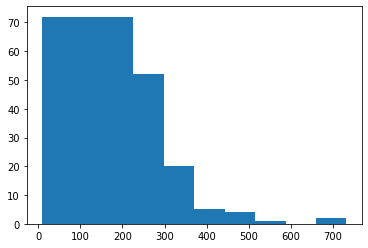

In [37]:
import matplotlib.pyplot as plt

print(max(frequency.keys()))

plt.hist(frequency)
plt.show()